In [ ]:
# Nos conectamos a nuestro conjunto de datos

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Conv2D, Activation, BatchNormalization, MaxPooling2D
from tensorflow.keras import optimizers, Model
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import locale
from matplotlib import image as mpimg
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16


# optimizador de la red por medio de Bayessian Optimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization


2023-02-16 08:17:20.918138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-16 08:17:20.918158: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


You should consider upgrading via the '/home/ubuntu/PycharmProjects/deep-learning-rogelio/venv/bin/python -m pip install --upgrade pip' command.


In [4]:
# Abrimos nuestros dataset para prepararlo
# ./drive/MyDrive/deep-learning-rogelio/train_data.csv

df_train = pd.read_csv('train_data.csv', sep=';', decimal='.')
print(df_train.shape)

# ./drive/MyDrive/deep-learning-rogelio/test_data.csv
df_test = pd.read_csv('test_data.csv', sep=';', decimal='.')
print(df_test.shape)

# Vamos a abrir las imágenes
# ./drive/MyDrive/deep-learning-rogelio/trainImagesX.npy
trainImagesX = np.load("trainImagesX.npy")
print(trainImagesX.shape)

# Abrimos las imagenes de test
# ./drive/MyDrive/deep-learning-rogelio/testImagesX.npy
testImagesX = np.load("testImagesX.npy")
print(testImagesX.shape)


(750, 22)
(250, 22)
(750, 224, 224, 3)
(250, 224, 224, 3)


In [5]:
x_train_images = trainImagesX / 255
x_test_images = testImagesX / 255

In [6]:
# Hacemos el split de train y validation para las imágenes y los atributos
# Lo hacemos con el dataframe completo, aún no separamos los valores

split = train_test_split(df_train, x_train_images, test_size=0.1, random_state=42)
(trainAttrX, valAttrX, trainImagesX, valImagesX) = split

In [7]:
# Separamos x_train, y_train y convertimos a numpy
x_train = trainAttrX.drop(['Price'], axis=1).values
y_train = trainAttrX['Price'].values

x_val = valAttrX.drop(['Price'], axis=1).values
y_val = valAttrX['Price'].values

# Separamos x_test, y_test y convertimos a numpy
x_test = df_test.drop(['Price'], axis=1).values
y_test = df_test['Price'].values

In [8]:
from sklearn.preprocessing import MinMaxScaler
# Create the scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(x_train)

# Transform the training and test data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [10]:
trainImagesX

array([[[[0.75294118, 0.71764706, 0.69803922],
         [0.75686275, 0.72156863, 0.70196078],
         [0.76078431, 0.7254902 , 0.70588235],
         ...,
         [0.59607843, 0.42352941, 0.37254902],
         [0.54901961, 0.38431373, 0.3372549 ],
         [0.62745098, 0.47058824, 0.42352941]],

        [[0.75294118, 0.71764706, 0.69803922],
         [0.75294118, 0.71764706, 0.69803922],
         [0.75686275, 0.72156863, 0.70196078],
         ...,
         [0.47843137, 0.30196078, 0.24705882],
         [0.43529412, 0.26666667, 0.21960784],
         [0.51372549, 0.35294118, 0.30196078]],

        [[0.75294118, 0.71764706, 0.69803922],
         [0.75294118, 0.71764706, 0.69803922],
         [0.75686275, 0.72156863, 0.70196078],
         ...,
         [0.35294118, 0.17254902, 0.11372549],
         [0.31372549, 0.1372549 , 0.08627451],
         [0.39607843, 0.23137255, 0.17254902]],

        ...,

        [[0.60392157, 0.60392157, 0.64705882],
         [0.58039216, 0.58039216, 0.61960784]

In [11]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import metrics 

# Load the ResNet50V2 model without the top layers and set it to non-trainable
# base_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False

# Add a custom top to the model for regression
x = layers.Flatten()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='linear')(x)

# Compile the model
model = models.Model(base_model.input, x)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse', 
              metrics=[
                  metrics.MeanAbsoluteError(), 
                  metrics.MeanSquaredError(), 
                  metrics.RootMeanSquaredError()])

# Define the callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(trainImagesX, x_train, batch_size=128, epochs=50, validation_data=(valImagesX, x_val), callbacks=[early_stopping, reduce_lr], verbose=1)

# Evaluate the model on the test set
test_pred = model.predict(x_test_images)
mse = mean_squared_error(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)


2023-02-16 08:43:40.157965: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-16 08:43:40.157990: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-16 08:43:40.158010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu-ThinkPad-P15-Gen-1): /proc/driver/nvidia/version does not exist
2023-02-16 08:43:40.158397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58889256/58889256 [==============================] - 2s 0us/step
Epoch 1/50
6/6 [==============================] - 58s 10s/step - loss: 0.5587 - mean_absolute_error: 0.5966 - mean_squared_error: 0.5587 - root_mean_squared_error: 0.7475 - val_loss: 0.2874 - val_mean_absolute_error: 0.3946 - val_mean_squared_error: 0.2874 - val_root_mean_squared_error: 0.5361 - lr: 1.0000e-04
Epoch 2/50
6/6 [==============================] - 60s 10s/step - loss: 0.2589 - mean_absolute_error: 0.4158 - mean_squared_error: 0.2589 - root_mean_squared_error: 0.5088 - val_loss: 0.2223 - val_mean_absolute_error: 0.4296 - val_mean_squared_error: 0.2223 - val_root_mean_squared_error: 0.4715 - lr: 1.0000e-04
Epoch 3/50
6/6 [==============================] - 61s 10s/step - loss: 0.2014 - mean_absolute_error: 0.3800 - mean_squared_error: 0.2014 - root_mean_squared_error: 0.4488 - val_loss: 0.1769 - val_mean_absolute_error: 0.3185 - val_mean_squared_error: 0.1769 - val_root_mean_squared_error: 0.4205 - lr: 1.0000e-04

[INFO] avg. house price: $64.59, std house price: $55.36
[INFO] mean: 99.25%, std: 0.48%


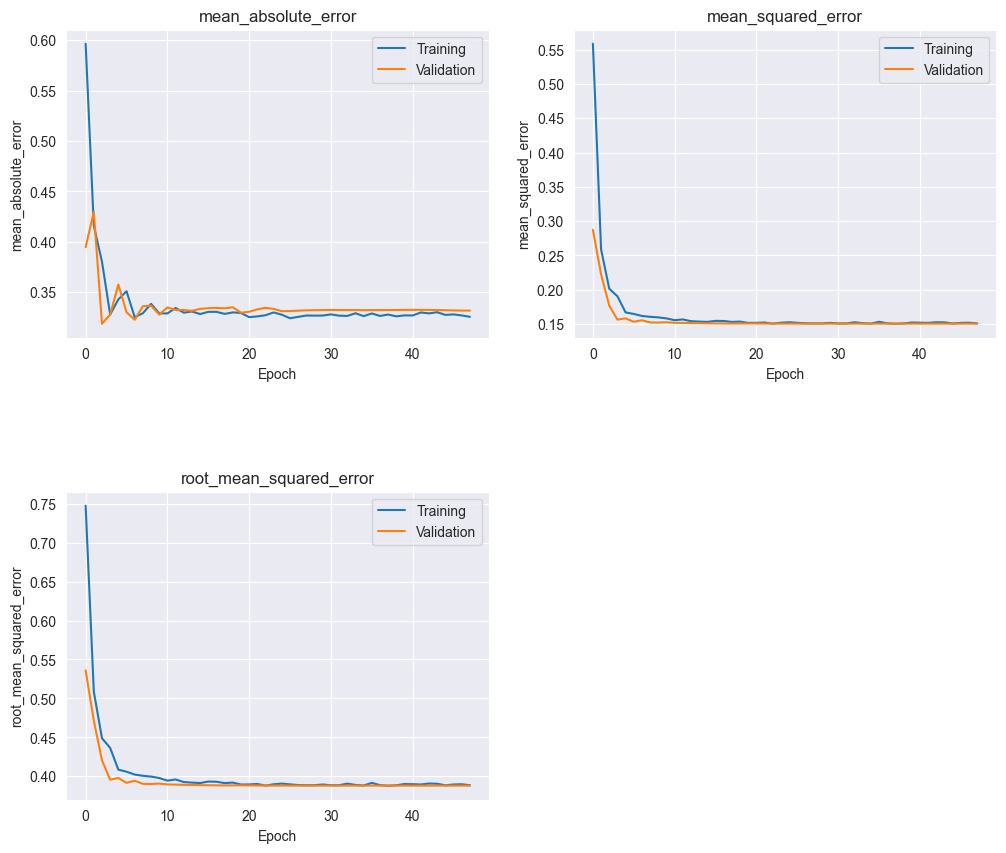

In [12]:
diff = test_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df_train["Price"].mean(), grouping=True),
    locale.currency(df_train["Price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
 # Create a grid of subplots that shares the y-axis across rows and the x-axis across columns
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])

# Plot the training and validation curves for each metric
for i, metric in enumerate(['mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    ax.plot(history.history[metric], label='Training')
    ax.plot(history.history['val_' + metric], label='Validation')
    ax.set_title(metric)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend(loc='upper right')
plt.show()

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Define the model architecture
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=[
    metrics.MeanAbsoluteError(),
                  metrics.MeanSquaredError(),
                  metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(trainImagesX, x_train, epochs=10, validation_data=(valImagesX, x_val), batch_size=32)

# Evaluate the model on test data
#test_loss, test_mae, test_mse, test_msle = model.evaluate(valImagesX, valImagesX)

# Make predictions on new data

test_pred = model.predict(x_test_images)
mse = mean_squared_error(y_test, test_pred)
mae = mean_absolute_error(y_test, test_pred)
r2 = r2_score(y_test, test_pred)

# Print the evaluation metrics
print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)


Epoch 1/10
22/22 [==============================] - 19s 845ms/step - loss: 9.3954 - mean_absolute_error: 1.0227 - mean_squared_error: 9.3954 - root_mean_squared_error: 3.0652 - val_loss: 0.1444 - val_mean_absolute_error: 0.3324 - val_mean_squared_error: 0.1444 - val_root_mean_squared_error: 0.3800
Epoch 2/10
22/22 [==============================] - 18s 808ms/step - loss: 0.1441 - mean_absolute_error: 0.3297 - mean_squared_error: 0.1441 - root_mean_squared_error: 0.3795 - val_loss: 0.1442 - val_mean_absolute_error: 0.3275 - val_mean_squared_error: 0.1442 - val_root_mean_squared_error: 0.3797
Epoch 3/10
22/22 [==============================] - 16s 742ms/step - loss: 0.1445 - mean_absolute_error: 0.3310 - mean_squared_error: 0.1445 - root_mean_squared_error: 0.3801 - val_loss: 0.1510 - val_mean_absolute_error: 0.3097 - val_mean_squared_error: 0.1510 - val_root_mean_squared_error: 0.3885
Epoch 4/10
22/22 [==============================] - 17s 770ms/step - loss: 0.1457 - mean_absolute_error

[INFO] avg. house price: $64.59, std house price: $55.36
[INFO] mean: 99.24%, std: 0.47%


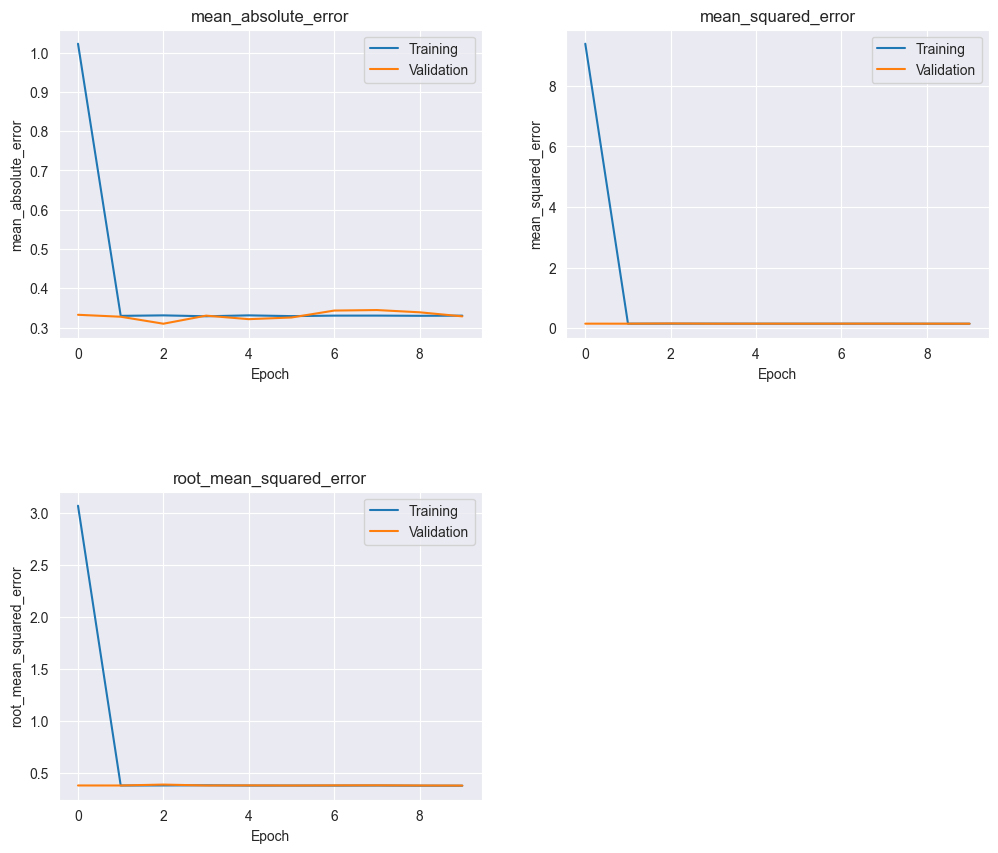

In [18]:
diff = test_pred.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
    locale.currency(df_train["Price"].mean(), grouping=True),
    locale.currency(df_train["Price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))
 # Create a grid of subplots that shares the y-axis across rows and the x-axis across columns
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2, figure=fig, hspace=0.5, wspace=0.2, height_ratios=[1, 1])

# Plot the training and validation curves for each metric
for i, metric in enumerate(['mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error']):
    row = i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    ax.plot(history.history[metric], label='Training')
    ax.plot(history.history['val_' + metric], label='Validation')
    ax.set_title(metric)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend(loc='upper right')
plt.show()

In [ ]:
for image in trainImagesX:
    if image.shape >= (224, 224, 4):
        print(image.shape)
        plt.imshow(image)
        plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Escalamos las imagenes
scaler = MinMaxScaler()
x_train_images = scaler.fit_transform(trainImagesX)
x_test_images = scaler.fit_transform(testImagesX)

In [ ]:
# Hacemos el split de train y test para las imágenes y los atributos
# Lo hacemos con el dataframe completo, aún no separamos los valores

split = train_test_split(df_train, x_train_images, test_size=0.1, random_state=42)
(trainAttrX, valAttrX, trainImagesX, valImagesX) = split

In [ ]:
# Separamos x_train, y_train y convertimos a numpy
x_train = trainAttrX.drop(['Price'], axis=1).values
y_train = trainAttrX['Price'].values

# Separamos x_test, y_test y convertimos a numpy
x_test = df_test.drop(['Price'], axis=1).values
y_test = df_test['Price'].values

In [ ]:
# Create the scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(x_train)

# Transform the training and test data
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
# construimos el modelo base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()


In [19]:



def train_deep_net(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model


In [24]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 100
INIT_LR = 1e-3
BS = 32

model = train_deep_net(width=224, height=224, depth=3, regress=True)
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt, metrics=["mae"])



In [25]:
# train the model
print("[INFO] training model...")
history = model.fit(trainImagesX, x_train,
                    validation_data=(valImagesX, x_val),
                    epochs=EPOCHS,
                    batch_size=BS)



[INFO] training model...
Epoch 1/100
22/22 [==============================] - 13s 556ms/step - loss: 98442200.0000 - mae: 0.8637 - val_loss: 25358678.0000 - val_mae: 0.5013
Epoch 2/100
22/22 [==============================] - 12s 563ms/step - loss: 73055976.0000 - mae: 0.7318 - val_loss: 16462882.0000 - val_mae: 0.4431
Epoch 3/100
22/22 [==============================] - 13s 597ms/step - loss: 55405128.0000 - mae: 0.5905 - val_loss: 27770372.0000 - val_mae: 0.3052
Epoch 4/100
22/22 [==============================] - 12s 546ms/step - loss: 42136212.0000 - mae: 0.5243 - val_loss: 74395320.0000 - val_mae: 0.3591
Epoch 5/100
22/22 [==============================] - 12s 537ms/step - loss: 40005780.0000 - mae: 0.5107 - val_loss: 29971064.0000 - val_mae: 0.3232
Epoch 6/100
22/22 [==============================] - 13s 574ms/step - loss: 34273796.0000 - mae: 0.4920 - val_loss: 6990517.5000 - val_mae: 0.3494
Epoch 7/100
 5/22 [=====>........................] - ETA: 10s - loss: 35253216.0000 - ma

KeyboardInterrupt: 

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x_test_images)
diff = predictions.flatten() - y_test
percentDiff = (diff / y_test) * 100
absPercentDiff = np.abs(percentDiff)
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(df_train["price"].mean(), grouping=True),
	locale.currency(df_train["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

